# Problem
The new test for solving pde using pytorch:

$
\frac{\partial{u}}{\partial t} = \frac{\partial^2 u}{\partial{x}^2}+\frac{\partial^2 u}{\partial{y}^2}
$

in the square region $0 \le x \le 2$ and $ 0 \le y \le 2$
for the time $0 \le t \le 2$

Independent variables:
* t - time
* x - coordinate
* y - coordinate

Dependent variables output:
* u - diffusion species

In [10]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import numpy as np

In [12]:
# rewrite in layer, this is rather boilplate code 
class DiffNet(nn.Module):
    def __init__(self, input_size,hidden_size,
                output_size, depth, act=torch.nn.Tanh):
        super(DiffNet, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' %i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' %i,act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))
        
        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)
    
    def forward(self, x,y,t):
        inputs = torch.cat([x,y,t], axis = 1)
        out = self.layers(inputs)
        return out

Differential model for this equation is very similar as for one-dimensional case.
* predict out based on the coordinates $x, y$ and time $t$.

In [13]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        # build model
        self.model = DiffNet(
               input_size=3,
               hidden_size=20,
               output_size=1,
               depth=3,
               act=torch.nn.Tanh).to(device)
        
        # Initial and boundary conditions
        x = np.random.uniform(low=0.,high=2., size=(141,1))
        y = np.random.uniform(low=0.,high=2., size=(141,1))
        t = np.random.uniform(low=0.,high=2., size=(141,1))
        t_bc = np.zeros((141,1))
        
        self.x_bc = torch.from_numpy(x).float().to(device)
        self.x_bc.requires_grad = False
        self.y_bc = torch.from_numpy(y).float().to(device)
        self.y_bc.requires_grad = False
        self.t_bc = torch.from_numpy(t_bc).float().to(device)
        self.t_bc.requires_grad = False
        
        self.x = torch.from_numpy(x).float().to(device)
        self.x.requires_grad = True
        self.y = torch.from_numpy(y).float().to(device)
        self.y.requires_grad = True
        self.t = torch.from_numpy(t).float().to(device)
        self.t.requires_grad = True
        self.all_zeros = torch.zeros_like(self.x).to(device)
        self.all_zeros.requires_grad = False
        
        #initial and boundary condition 
        self.u_init = self.analytic_sol_func(torch.zeros_like(self.t_bc), self.x_bc, self.y_bc)
        self.u_xmin = self.analytic_sol_func(self.t_bc, torch.zeros_like(self.x_bc), self.y_bc)
        self.u_xmax = self.analytic_sol_func(self.t_bc, torch.ones_like(self.x_bc)*2.0, self.y_bc)
        self.u_ymin = self.analytic_sol_func(self.t_bc, self.x_bc, torch.zeros_like(self.y_bc))
        self.u_ymax = self.analytic_sol_func(self.t_bc, self.x_bc, torch.ones_like(self.y_bc)*2.0)
        
        
        self.mse_cost_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.iter = 0
        
    def analytic_sol_func(self, t, x, y): 
        return torch.exp(x + y) * torch.cos(x + y + 4*t)
    
    def f(self, x, y, t):
        u = self.model(x,y,t) 
             
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_y = torch.autograd.grad(
            u, y, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_yy = torch.autograd.grad(
            u_y, y, 
            grad_outputs=torch.ones_like(u_y),
            retain_graph=True,
            create_graph=True
        )[0]
        
        return u_t - u_xx - u_yy
    
    def loss_func(self):
        self.optimizer.zero_grad()
    
        # initial boundary condition
        out = self.model(self.x_bc, self.y_bc, self.t_bc)
        mse_u = self.mse_cost_function(out, self.u_init)
    
    
        # boundary conditions
        out = self.model(torch.zeros_like(self.x_bc), self.y_bc, self.t_bc)
        mse_u_xmin = self.mse_cost_function(out, self.u_xmin)
        
        out = self.model(torch.ones_like(self.x_bc)*2.0, self.y_bc, self.t_bc)
        mse_u_xmax = self.mse_cost_function(out, self.u_xmax)
        
        out = self.model(self.x_bc, torch.zeros_like(self.y_bc), self.t_bc)
        mse_u_ymin = self.mse_cost_function(out, self.u_ymin)
        
        out = self.model(self.x_bc, torch.ones_like(self.y_bc)*2.0, self.t_bc)
        mse_u_ymax = self.mse_cost_function(out, self.u_ymax)
        
        # fix condition for PDE
        out = self.f(self.x, self.y, self.t)
        mse_f = self.mse_cost_function(out, self.all_zeros)
    
        loss = mse_u + mse_u_xmax + mse_u_xmin + mse_u_ymax + mse_u_ymin + mse_f
        loss.backward()
        
        if self.iter % 100 == 0:
            print(f" Iter: {self.iter}, loss:{loss.data}")
            
        self.iter += 1
        return loss
        
    def train(self,epochs):
        for epoch in range(epochs):
            self.optimizer.step(self.loss_func)

In [14]:
net = Net()
net.train(10000)

 Iter: 0, loss:1006.061767578125
 Iter: 100, loss:705.1713256835938
 Iter: 200, loss:541.04052734375
 Iter: 300, loss:423.9929504394531
 Iter: 400, loss:343.34930419921875
 Iter: 500, loss:279.7746276855469
 Iter: 600, loss:225.227783203125
 Iter: 700, loss:182.21937561035156
 Iter: 800, loss:149.41004943847656
 Iter: 900, loss:123.96136474609375
 Iter: 1000, loss:103.17769622802734
 Iter: 1100, loss:85.7814712524414
 Iter: 1200, loss:71.21319580078125
 Iter: 1300, loss:58.772830963134766
 Iter: 1400, loss:48.35826110839844
 Iter: 1500, loss:39.725555419921875
 Iter: 1600, loss:32.60109329223633
 Iter: 1700, loss:26.734790802001953
 Iter: 1800, loss:21.91422462463379
 Iter: 1900, loss:17.962736129760742
 Iter: 2000, loss:14.728034019470215
 Iter: 2100, loss:12.076191902160645
 Iter: 2200, loss:9.89382553100586
 Iter: 2300, loss:8.09151840209961
 Iter: 2400, loss:6.601047515869141
 Iter: 2500, loss:5.369747161865234
 Iter: 2600, loss:4.3573527336120605
 Iter: 2700, loss:3.52544164657592

In [21]:
net.train(10000)

 Iter: 10000, loss:0.002754986984655261
 Iter: 10100, loss:0.002702479250729084
 Iter: 10200, loss:0.0814814418554306
 Iter: 10300, loss:0.002619771286845207
 Iter: 10400, loss:0.00256924144923687
 Iter: 10500, loss:0.0025773169472813606
 Iter: 10600, loss:0.0025007687509059906
 Iter: 10700, loss:0.002442591357976198
 Iter: 10800, loss:0.008739323355257511
 Iter: 10900, loss:0.00236550928093493
 Iter: 11000, loss:0.002323167398571968
 Iter: 11100, loss:0.0033445085864514112
 Iter: 11200, loss:0.0022523747757077217
 Iter: 11300, loss:0.0022147484123706818
 Iter: 11400, loss:0.0022046766243875027
 Iter: 11500, loss:0.0021454687230288982
 Iter: 11600, loss:0.0039013801142573357
 Iter: 11700, loss:0.0020822440274059772
 Iter: 11800, loss:0.002046729438006878
 Iter: 11900, loss:0.002110295696184039
 Iter: 12000, loss:0.0019883413333445787
 Iter: 12100, loss:0.10798030346632004
 Iter: 12200, loss:0.0019351637456566095
 Iter: 12300, loss:0.0019005880458280444
 Iter: 12400, loss:0.003836061339

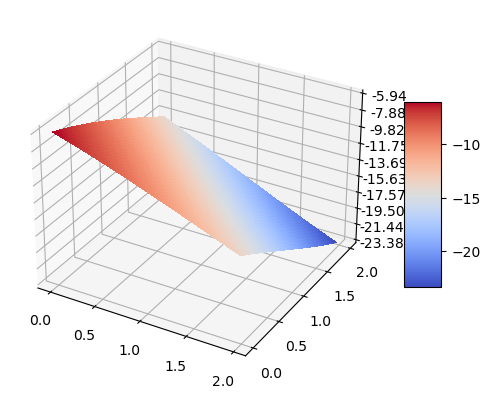

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = plt.axes(projection='3d')

x = np.arange(0,2,0.02)
y = np.arange(0,2,.02)
xm, ym = np.meshgrid(x,y)

x = np.ravel(xm).reshape(-1,1)
y = np.ravel(ym).reshape(-1,1)

x_input = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
y_input = Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)

u_pred = net.model(x_input, y_input, torch.ones_like(x_input)*2.0)
um = u_pred.data.cpu().numpy()
um = um.reshape(xm.shape)

surf = ax.plot_surface(xm, ym, um, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=.5, aspect=5)
plt.show()

In [23]:
def solution(x,y,t):
    return np.exp(x + y) * np.cos(x + y + 4*t)
anal_sol = solution(x,y,2)
mse=np.mean((anal_sol-u_pred.data.cpu().numpy())**2)


In [24]:
mse

201.05810234498804